<img src="mioti.png" style="height: 100px">
<center style="color:#888">Data science fundamentals <br/>Predictive Analytics</center>

# Worksheet S2: Introducción a los Modelos de Previsión en Series Temporales

## Caso práctico: Predicción de los Alquileres de Bicicletas en Chicago

## 0. Objetivo

El objetivo de este worksheet es experimentar sobre modelos sencillos de **previsión de Series Temporales** para familiarizarnos con los principales conceptos de la modelización y previsión de variables. Para ello, vamos a seguir utilizando el caso práctico de los alquileres de bicicletas en Chicago.

<img src="bicicletas_chicago.jpg" style="float:right; height: 250px"></img>
Recordemos: la ciudad de Chicago cuenta con una red de alquileres de bicicletas y tiene un problema con su servicio, ya que más de un ** 20% ** de las estaciones se encuentra sin bicicletas cuando un usuario se acerca a alquilar una de ellas. Por este motivo, necesitan cambiar la forma de gestionar las estaciones de bicicletas. 

Para ello, vamos a realizar unas previsiones a largo y medio plazo para intentar **reducir la incertidumbre** a la hora de saber cuántas bicicletas se necesitan en cada momento.

Nuestro objetivo es realizar una **previsión** sobre cuál va a ser el alquiler de bicicletas en los **dos próximos años**.

## 1. Preparar el contexto

Como paso previo, cargamos las librerías que serán necesarias en nuestro estudio.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Obtener los datos

Como en otras ocasiones, vamos a importar los datos de un fichero csv, a través de la función **read_csv** que nos proporciona la librería de Pandas.

In [2]:
data_path = 'year_chicago.csv'
df_datos = pd.read_csv(data_path)

A continuación, comprobamos **qué hemos cargado**. Utilizando las funciones *info(), describe()* y *head()* podemos hacer un primer análisis de los datos cargados. Veamos que contiene nuestro dataset de partida:

In [3]:
df_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cnt     7 non-null      float64
 1   date    7 non-null      object 
dtypes: float64(1), object(1)
memory usage: 240.0+ bytes


In [4]:
df_datos.describe()

,cnt
count,7.000000e+00
mean,3.661109e+06
std,1.738479e+06
min,1.243103e+06
25%,2.463950e+06
50%,3.654785e+06
75%,4.860350e+06
max,6.081273e+06


In [5]:
df_datos

,cnt,date
0,1243103.0,2011-12-31
1,2049576.0,2012-12-31
2,2878325.0,2013-12-31
3,3654785.0,2014-12-31
4,4445789.0,2015-12-31
5,5274912.0,2016-12-31
6,6081273.0,2017-12-31


Este dataset contiene el **histórico de alquileres de los últimos 7 años a nivel año**, para la variable *cnt*, que era el número de bicicletas alquiladas, que a su vez está compuesto por la suma de los campos 'registered' y 'causal' (usuarios registrados y esporádicos).

## 3. Pretratado de los datos

Como vimos en la sesión anterior, al trabajar con series temporales, no debemos olvidar que una de nuestras variables va a ser el **tiempo**. Por este motivo, es muy interesante tener un campo que sea de tipo **datetime**, ya que Pandas interpreta y ofrece múltiples herramientas que facilitan el trabajo con este tipo de datos.

In [6]:
df_datos['date'] = pd.to_datetime(df_datos['date'], format='%Y-%m-%d')
## Creamos un dataframe cuyo índice sea el campo fecha y que contenga nuestra variable cnt
df_alquileres = pd.DataFrame(df_datos['cnt'].tolist(),
                             index = df_datos['date'].tolist(),
                             columns = ['cnt'])
df_alquileres

,cnt
2011-12-31,1243103.0
2012-12-31,2049576.0
2013-12-31,2878325.0
2014-12-31,3654785.0
2015-12-31,4445789.0
2016-12-31,5274912.0
2017-12-31,6081273.0


Nuestro objetivo es realizar una **previsión** sobre el alquiler de bicicletas para los próximos **dos años**. Para ello, vamos a incluir en nuestro dataframe dos nuevos registros (ahora mismo vacíos) para los años en los que queremos hacer la previsión.

- Nuestro dataframe será: histórico de alquileres anuales + 2 años para nuestras previsiones

In [28]:
## Necesitamos incluir dos periodos más a nuestro dataframe, con la función date_range es muy fácil.
## Como es predicción anual, nuestra frecuencia será anual.
periodos = pd.date_range('2018-03-31', periods = 2, freq = 'A')
periodos

DatetimeIndex(['2018-12-31', '2019-12-31'], dtype='datetime64[ns]', freq='A-DEC')

In [29]:
## Creamos un dataframe con nuestras fechas a predecir
df_prediccion = pd.DataFrame({'cnt':[np.nan,np.nan]},
                             index = periodos)
df_prediccion

,cnt
2018-12-31,nan
2019-12-31,nan


In [30]:
## Unimos el dataframe del histórico y el de la predicción
df_alquileres = pd.concat([df_alquileres, df_prediccion], ignore_index = False)
df_alquileres

,cnt,prevision_M1,cnt_shift,var AA,prevision_M2,prevision_M3,cnt_sin_tend,prevision_M3_st,prevision_M3_ct
2011-12-31,"1,243,103.0",nan,nan,nan,nan,nan,nan,nan,nan
2012-12-31,"2,049,576.0",nan,"1,243,103.0","806,473.0",nan,nan,"806,473.0",nan,nan
2013-12-31,"2,878,325.0",nan,"2,049,576.0","828,749.0",nan,nan,"828,749.0",nan,nan
2014-12-31,"3,654,785.0",nan,"2,878,325.0","776,460.0",nan,nan,"776,460.0",nan,nan
2015-12-31,"4,445,789.0",nan,"3,654,785.0","791,004.0",nan,nan,"791,004.0",nan,nan
2016-12-31,"5,274,912.0",nan,"4,445,789.0","829,123.0",nan,nan,"829,123.0",nan,nan
2017-12-31,"6,081,273.0","6,081,273.0","5,274,912.0","806,361.0","6,081,273.0","6,081,273.0","806,361.0","806,361.7","6,081,273.0"
2018-12-31,nan,"6,081,273.0","6,081,273.0","806,361.0","6,887,634.0","3,661,109.0",nan,"806,361.7","6,887,634.7"
2019-12-31,nan,"6,081,273.0",nan,"806,361.0","7,693,995.0","3,661,109.0",nan,"806,361.7","7,693,996.3"
2018-12-31,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [10]:
## Modificamos el formato de muestra del dataframe para que sea más fácil leerlo
pd.options.display.float_format = '{:,.1f}'.format
df_alquileres

,cnt
2011-12-31,"1,243,103.0"
2012-12-31,"2,049,576.0"
2013-12-31,"2,878,325.0"
2014-12-31,"3,654,785.0"
2015-12-31,"4,445,789.0"
2016-12-31,"5,274,912.0"
2017-12-31,"6,081,273.0"
2018-12-31,nan
2019-12-31,nan


**P: ¿Qué componentes de una serie temporal tiene el alquiler de bicicletas anual?**

In [11]:
#TENDENCIA

Para responder a esta pregunta, vamos a representar la serie temporal:

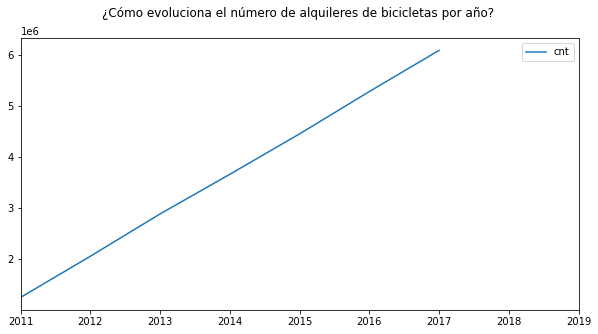

In [12]:
df_alquileres.plot(figsize=(10,5),
                  title='¿Cómo evoluciona el número de alquileres de bicicletas por año? \n')

Al tener la serie temporal agregada por años, no tenemos ningún tipo de estacionalidad, pero sí tenemos **tendencia**.

## 4. Primeras previsiones

Nuestro objetivo es realizar la previsión de los alquileres de bicicletas para los próximos dos años: 2018 y 2019.

**P: ¿Cuál es el modelo de previsión más sencillo que se os ocurre?**

### 4.1.- Modelo 1

Vamos a comenzar con un modelo sencillo, simplemente tomaremos como previsión los alquileres del último año.

#### *Mi previsión de alquileres = Alquileres último año*

In [13]:
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_alquileres['prevision_M1']=np.nan
## Igualamos los dos últimos años en los que vamos a hacer la previsión al valor del último año de histórico
df_alquileres['prevision_M1'][-3:]=df_alquileres['cnt'][-3]
df_alquileres

,cnt,prevision_M1
2011-12-31,"1,243,103.0",nan
2012-12-31,"2,049,576.0",nan
2013-12-31,"2,878,325.0",nan
2014-12-31,"3,654,785.0",nan
2015-12-31,"4,445,789.0",nan
2016-12-31,"5,274,912.0",nan
2017-12-31,"6,081,273.0","6,081,273.0"
2018-12-31,nan,"6,081,273.0"
2019-12-31,nan,"6,081,273.0"


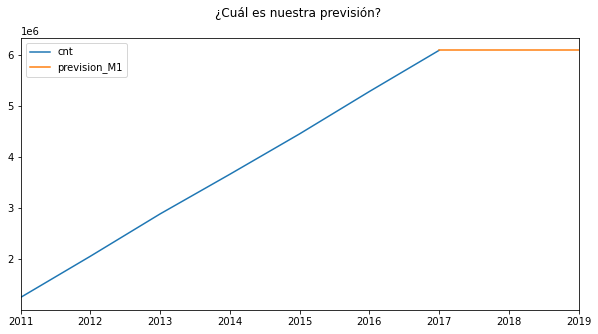

In [14]:
## Representamos nuestra previsión
df_alquileres.plot(figsize=(10,5),
                  title='¿Cuál es nuestra previsión? \n')

**P: ¿Qué le pasa a mi previsión? ¿Se os ocurre cómo mejorarla?**

Como esperábamos nuestra previsión deja mucho que desear, pues no hemos tenido en cuenta que nuestra serie temporal tiene tendencia.

Probemos a incorporar la variación del último año a la previsión del modelo 1.

### 4.2.- Modelo 2

Vamos a intentar mejorar nuestra previsión de alquileres, teniendo en cuenta la variación del último año.

**Mi previsión de alquileres = Alquileres último año + la variación del último año**

In [15]:
## Hacemos un desplazamiento de nuestra variable para calcular esa variación
df_alquileres['cnt_shift'] = df_alquileres['cnt'].shift(1)
df_alquileres['var AA'] = df_alquileres['cnt'] - df_alquileres['cnt_shift']
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_alquileres['prevision_M2']=np.nan
## Igualamos el último valor al registro correspondiente de la nueva variable (para que se vea mejor la representación)
df_alquileres['prevision_M2'][-3] = df_alquileres['cnt'][-3]
df_alquileres

,cnt,prevision_M1,cnt_shift,var AA,prevision_M2
2011-12-31,"1,243,103.0",nan,nan,nan,nan
2012-12-31,"2,049,576.0",nan,"1,243,103.0","806,473.0",nan
2013-12-31,"2,878,325.0",nan,"2,049,576.0","828,749.0",nan
2014-12-31,"3,654,785.0",nan,"2,878,325.0","776,460.0",nan
2015-12-31,"4,445,789.0",nan,"3,654,785.0","791,004.0",nan
2016-12-31,"5,274,912.0",nan,"4,445,789.0","829,123.0",nan
2017-12-31,"6,081,273.0","6,081,273.0","5,274,912.0","806,361.0","6,081,273.0"
2018-12-31,nan,"6,081,273.0","6,081,273.0",nan,nan
2019-12-31,nan,"6,081,273.0",nan,nan,nan


In [16]:
## Rellenamos la variable con la variación, replicando el último valor hasta el final
## ffill: propagate last valid observation forward to next valid backfill
df_alquileres['var AA']=df_alquileres['var AA'].fillna(method='ffill')
## Sumamos el acumulado de esa variación a la previsión que tenemos del modelo 1
df_alquileres['prevision_M2'][-2:] = df_alquileres['var AA'][-2:].cumsum() +\
                                     df_alquileres['prevision_M1'][-2:]
df_alquileres

,cnt,prevision_M1,cnt_shift,var AA,prevision_M2
2011-12-31,"1,243,103.0",nan,nan,nan,nan
2012-12-31,"2,049,576.0",nan,"1,243,103.0","806,473.0",nan
2013-12-31,"2,878,325.0",nan,"2,049,576.0","828,749.0",nan
2014-12-31,"3,654,785.0",nan,"2,878,325.0","776,460.0",nan
2015-12-31,"4,445,789.0",nan,"3,654,785.0","791,004.0",nan
2016-12-31,"5,274,912.0",nan,"4,445,789.0","829,123.0",nan
2017-12-31,"6,081,273.0","6,081,273.0","5,274,912.0","806,361.0","6,081,273.0"
2018-12-31,nan,"6,081,273.0","6,081,273.0","806,361.0","6,887,634.0"
2019-12-31,nan,"6,081,273.0",nan,"806,361.0","7,693,995.0"


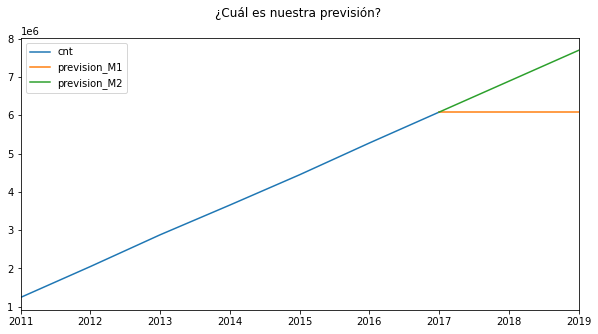

In [17]:
## Representamos nuestra previsión
df_alquileres.loc[:,['cnt','prevision_M1','prevision_M2']].plot(figsize=(10,5),
                  title='¿Cuál es nuestra previsión? \n')

**P: ¿Si comparamos las previsiones del M1 y el M2 en qué se diferencian?**

Hemos mejorado considerablemente la previsión al incluir el efecto tendencia de la serie.

### 4.3.- Modelo 3

**Mi previsión de alquileres = Media de TODOS los alquileres**

In [18]:
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_alquileres['prevision_M3'] = np.nan
## Igualamos el último valor al registro correspondiente de la nueva variable (para que se vea mejor la representación)
df_alquileres['prevision_M3'][-3] = df_alquileres['cnt'][-3]
## Igualamos los dos últimos años en los que vamos a hacer la previsión con la media de todos los alquileres
df_alquileres['prevision_M3'][-2:] = df_alquileres['cnt'].mean()
df_alquileres

,cnt,prevision_M1,cnt_shift,var AA,prevision_M2,prevision_M3
2011-12-31,"1,243,103.0",nan,nan,nan,nan,nan
2012-12-31,"2,049,576.0",nan,"1,243,103.0","806,473.0",nan,nan
2013-12-31,"2,878,325.0",nan,"2,049,576.0","828,749.0",nan,nan
2014-12-31,"3,654,785.0",nan,"2,878,325.0","776,460.0",nan,nan
2015-12-31,"4,445,789.0",nan,"3,654,785.0","791,004.0",nan,nan
2016-12-31,"5,274,912.0",nan,"4,445,789.0","829,123.0",nan,nan
2017-12-31,"6,081,273.0","6,081,273.0","5,274,912.0","806,361.0","6,081,273.0","6,081,273.0"
2018-12-31,nan,"6,081,273.0","6,081,273.0","806,361.0","6,887,634.0","3,661,109.0"
2019-12-31,nan,"6,081,273.0",nan,"806,361.0","7,693,995.0","3,661,109.0"


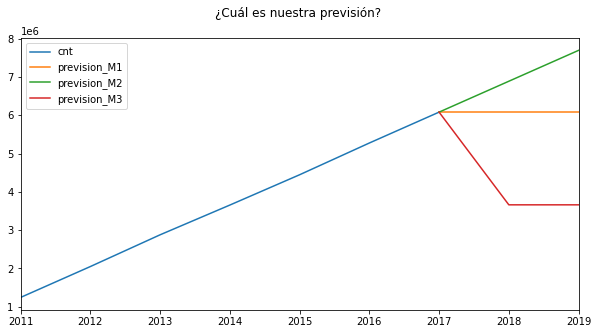

In [19]:
## Representamos nuestra previsión
df_alquileres.loc[:,['cnt','prevision_M1','prevision_M2','prevision_M3']].plot(figsize=(10,5),
                  title='¿Cuál es nuestra previsión? \n')

**P: ¿Qué le ha pasado ahora a mi prevision_M3?**

**P: ¿Cómo podría mejorar mi previsión del M3?**

Si el modelo tiene tendencia, no podemos aplicar medias, ya que como vemos, es la peor previsión que podemos tomar.

### 4.4.- Modelo 3 mejorado

Para mejorar nuestra previsión, vamos a **eliminar la componente principal de la serie (la tendencia)** y a realizar la predicción sobre la componente aleatoria.

In [20]:
## Eliminamos la tendencia
df_alquileres['cnt_sin_tend'] = df_alquileres['cnt'] - df_alquileres['cnt'].shift(1)
df_alquileres

,cnt,prevision_M1,cnt_shift,var AA,prevision_M2,prevision_M3,cnt_sin_tend
2011-12-31,"1,243,103.0",nan,nan,nan,nan,nan,nan
2012-12-31,"2,049,576.0",nan,"1,243,103.0","806,473.0",nan,nan,"806,473.0"
2013-12-31,"2,878,325.0",nan,"2,049,576.0","828,749.0",nan,nan,"828,749.0"
2014-12-31,"3,654,785.0",nan,"2,878,325.0","776,460.0",nan,nan,"776,460.0"
2015-12-31,"4,445,789.0",nan,"3,654,785.0","791,004.0",nan,nan,"791,004.0"
2016-12-31,"5,274,912.0",nan,"4,445,789.0","829,123.0",nan,nan,"829,123.0"
2017-12-31,"6,081,273.0","6,081,273.0","5,274,912.0","806,361.0","6,081,273.0","6,081,273.0","806,361.0"
2018-12-31,nan,"6,081,273.0","6,081,273.0","806,361.0","6,887,634.0","3,661,109.0",nan
2019-12-31,nan,"6,081,273.0",nan,"806,361.0","7,693,995.0","3,661,109.0",nan


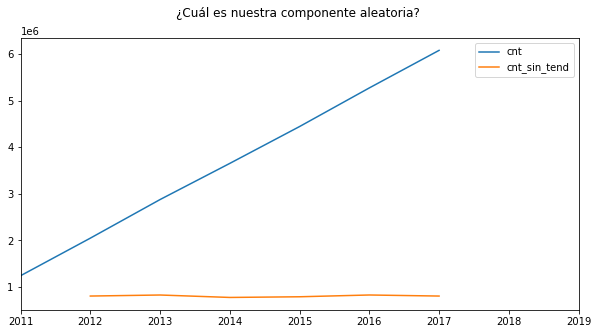

In [21]:
## Representamos nuestra serie
df_alquileres.loc[:,['cnt','cnt_sin_tend']].plot(figsize=(10,5),
                  title='¿Cuál es nuestra componente aleatoria? \n')

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11c31f2d0>,
      dtype=object)

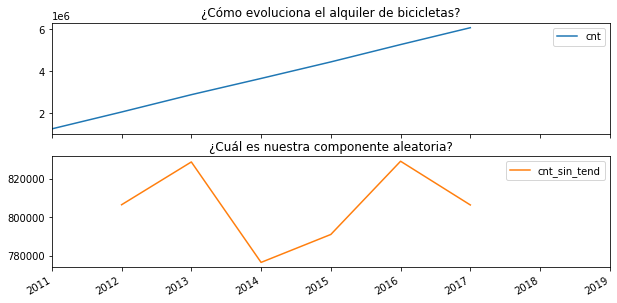

In [22]:
## Si la representamos en dos gráficos independientes, para que no nos engañen los rangos de las magnitudes
df_alquileres.loc[:,['cnt','cnt_sin_tend']].plot(figsize = (10,5),
                                                 subplots = True,
                                                 title = ['¿Cómo evoluciona el alquiler de bicicletas?',
                                                          '¿Cuál es nuestra componente aleatoria?'])

Aplicamos nuestro modelo 3 (Previsión de Alquileres = Media de Todos los alquileres) a la serie sin tendencia.

In [23]:
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_alquileres['prevision_M3_st']=np.nan
## Incluimos como previsión de los dos últimos meses la media de todos los alquileres
df_alquileres['prevision_M3_st'][-3:]=df_alquileres['cnt_sin_tend'].mean()
df_alquileres

,cnt,prevision_M1,cnt_shift,var AA,prevision_M2,prevision_M3,cnt_sin_tend,prevision_M3_st
2011-12-31,"1,243,103.0",nan,nan,nan,nan,nan,nan,nan
2012-12-31,"2,049,576.0",nan,"1,243,103.0","806,473.0",nan,nan,"806,473.0",nan
2013-12-31,"2,878,325.0",nan,"2,049,576.0","828,749.0",nan,nan,"828,749.0",nan
2014-12-31,"3,654,785.0",nan,"2,878,325.0","776,460.0",nan,nan,"776,460.0",nan
2015-12-31,"4,445,789.0",nan,"3,654,785.0","791,004.0",nan,nan,"791,004.0",nan
2016-12-31,"5,274,912.0",nan,"4,445,789.0","829,123.0",nan,nan,"829,123.0",nan
2017-12-31,"6,081,273.0","6,081,273.0","5,274,912.0","806,361.0","6,081,273.0","6,081,273.0","806,361.0","806,361.7"
2018-12-31,nan,"6,081,273.0","6,081,273.0","806,361.0","6,887,634.0","3,661,109.0",nan,"806,361.7"
2019-12-31,nan,"6,081,273.0",nan,"806,361.0","7,693,995.0","3,661,109.0",nan,"806,361.7"


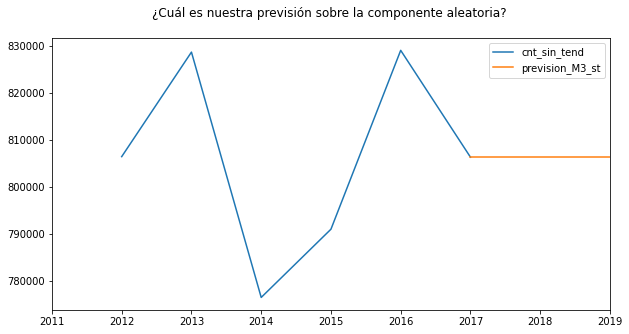

In [24]:
## Representamos nuestra previsión
df_alquileres.loc[:,['cnt_sin_tend','prevision_M3_st']].plot(figsize=(10,5),
                                                title='¿Cuál es nuestra previsión sobre la componente aleatoria? \n')

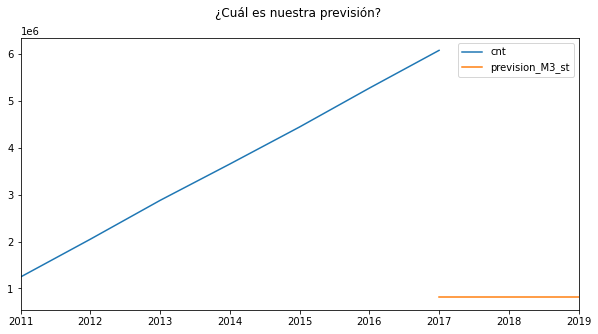

In [25]:
## Representamos nuestra previsión
df_alquileres.loc[:,['cnt','prevision_M3_st']].plot(figsize=(10,5),
                                                   title='¿Cuál es nuestra previsión? \n')

**P: Esta previsión M3_st ¿qué significa? ¿cómo lo puedo convertir en número que se parezca a mis alquileres?**

Hemos realizado nuestra previsión sobre la serie sin tendencia, pero no debemos olvidar que tras realizar ese cálculo, debemos volver a **incorporar la tendencia a nuestra previsión**.

In [26]:
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_alquileres['prevision_M3_ct'] = np.nan
## Sumamos el acumulado de la previsión a nuestra serie con tendencia
df_alquileres['prevision_M3_ct'][-3] = df_alquileres['cnt'][-3]
df_alquileres['prevision_M3_ct'][-2:] = df_alquileres['prevision_M3_st'][-2:].cumsum()\
                                      + df_alquileres['prevision_M1'][-2:]
df_alquileres

,cnt,prevision_M1,cnt_shift,var AA,prevision_M2,prevision_M3,cnt_sin_tend,prevision_M3_st,prevision_M3_ct
2011-12-31,"1,243,103.0",nan,nan,nan,nan,nan,nan,nan,nan
2012-12-31,"2,049,576.0",nan,"1,243,103.0","806,473.0",nan,nan,"806,473.0",nan,nan
2013-12-31,"2,878,325.0",nan,"2,049,576.0","828,749.0",nan,nan,"828,749.0",nan,nan
2014-12-31,"3,654,785.0",nan,"2,878,325.0","776,460.0",nan,nan,"776,460.0",nan,nan
2015-12-31,"4,445,789.0",nan,"3,654,785.0","791,004.0",nan,nan,"791,004.0",nan,nan
2016-12-31,"5,274,912.0",nan,"4,445,789.0","829,123.0",nan,nan,"829,123.0",nan,nan
2017-12-31,"6,081,273.0","6,081,273.0","5,274,912.0","806,361.0","6,081,273.0","6,081,273.0","806,361.0","806,361.7","6,081,273.0"
2018-12-31,nan,"6,081,273.0","6,081,273.0","806,361.0","6,887,634.0","3,661,109.0",nan,"806,361.7","6,887,634.7"
2019-12-31,nan,"6,081,273.0",nan,"806,361.0","7,693,995.0","3,661,109.0",nan,"806,361.7","7,693,996.3"


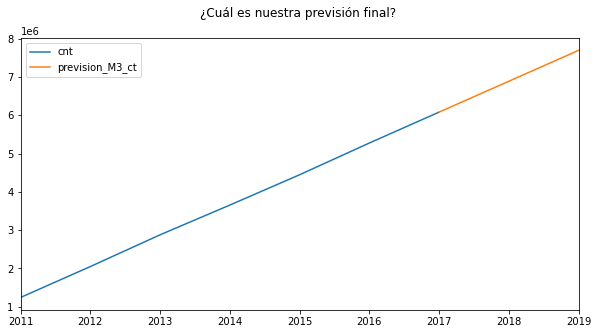

In [27]:
## Representamos nuestra previsión
df_alquileres.loc[:,['cnt','prevision_M3_ct']].plot(figsize=(10,5),
                                                     title='¿Cuál es nuestra previsión final? \n')

**P: ¿Cómo podríamos evolucionar el modelo 3 (el de la media)? ¿Se os ocurren otros modelos de previsión?**

* Alisados exponenciales
* Modelos ARIMA (AR - Autoregresivos , I - diferencias, MA -Medias móviles de los errores, aprender de los errores)